#Module

In [8]:
from Bio import SeqIO
import pandas as pd
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [11]:
df = pd.read_excel("../Dataset/Dataset_Preprocess_No-Sampling.xlsx")
df

,urutan,kelas
0,AGTTGTTAGTCTACGTGGACCGACAAAGACAGATTCTTTGAGGGAG...,0
1,AGTTGTTAGTCTACGTGGACCGACAAGAACAGTTTCGAATCGGAAG...,0
2,GTGGACCGCAAAGAACAGTTTCGAATCGGAAGCTTGCTTAACGTAG...,0
3,TTTCATTTTACCACACGTAACGGAGAACCACACATGATCGTCGGTA...,0
4,ATGAATAACCAACGAAAAAATGCGAGAAAAACGCCTTTCAATATGC...,0
...,...,...
1928,ATGAATAACCAACGGAAAAAGGCGAAAAACACGCCTTTCAATATGC...,1
1929,ATGAATAACCAACGGAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1
1930,ATGAACAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1
1931,ATGAATAACCAACGAAAAAAGGCGAGAAGTACGCCTTTCAATATGC...,1


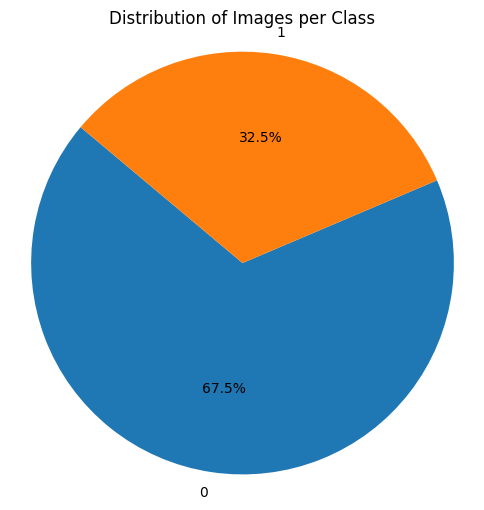

In [12]:
# Count the number of instances per class
class_counts = df['kelas'].value_counts()

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Class')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [13]:
# Fungsi untuk menghasilkan K-mers dengan panjang 3 dari urutan DNA
def get_kmers(sequence, k=3):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Fungsi untuk membuat mapping manual dari K-mers ke angka
def create_kmer_mapping(kmers_list):
    unique_kmers = set([kmer for kmers in kmers_list for kmer in kmers])
    kmer_to_index = {kmer: idx + 1 for idx, kmer in enumerate(unique_kmers)}
    return kmer_to_index

# Fungsi untuk mengonversi K-mers ke angka berdasarkan mapping
def map_kmers_to_indices(kmers, kmer_mapping):
    return [kmer_mapping[kmer] for kmer in kmers]

In [14]:
df['kmers'] = df['urutan'].apply(lambda x: get_kmers(x, 3))


kmer_mapping = create_kmer_mapping(df['kmers'])
print(f"Mapping dari K-mers ke angka: {kmer_mapping}")


df['encoded_kmers'] = df['kmers'].apply(lambda x: map_kmers_to_indices(x, kmer_mapping))


X = pad_sequences(df['encoded_kmers'].tolist(), padding='post')


y = df['kelas'].values


print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Mapping dari K-mers ke angka: {'CAG': 1, 'GAT': 2, 'TCC': 3, 'CCG': 4, 'GCC': 5, 'AAG': 6, 'ACT': 7, 'TGA': 8, 'CAT': 9, 'TGT': 10, 'AGG': 11, 'CCC': 12, 'GGA': 13, 'ATG': 14, 'ATA': 15, 'GGC': 16, 'GAG': 17, 'GCT': 18, 'GGT': 19, 'GCA': 20, 'AGT': 21, 'TAG': 22, 'CAC': 23, 'TCT': 24, 'ATT': 25, 'ACG': 26, 'ATC': 27, 'CTT': 28, 'CTC': 29, 'CCA': 30, 'CTA': 31, 'GGG': 32, 'TGG': 33, 'GTA': 34, 'TAT': 35, 'CGT': 36, 'CAA': 37, 'GAA': 38, 'CCT': 39, 'TTC': 40, 'AAA': 41, 'AAC': 42, 'TTG': 43, 'TAC': 44, 'CTG': 45, 'TCA': 46, 'GTC': 47, 'CGA': 48, 'GTT': 49, 'GCG': 50, 'GAC': 51, 'AGA': 52, 'ACA': 53, 'TTT': 54, 'AGC': 55, 'AAT': 56, 'TGC': 57, 'CGC': 58, 'GTG': 59, 'TAA': 60, 'TTA': 61, 'ACC': 62, 'TCG': 63, 'CGG': 64}
Shape of X: (1933, 12119)
Shape of y: (1933,)


In [15]:
len_seq = 145
X = X[:, :len_seq]

In [18]:
np.set_printoptions(threshold=np.inf)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Print shapes dari data yang sudah di-split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1546, 145)
Shape of X_test: (387, 145)
Shape of y_train: (1546,)
Shape of y_test: (387,)


In [20]:
from GCallbacks import PlotLosses, checkpoint_callback, TimeHistory, PlotTimes

# Inisialisasi callback
plot_losses_callback = PlotLosses()
time_callback = TimeHistory()
plot_times_callback = PlotTimes(time_callback)
call = [plot_losses_callback, time_callback, plot_times_callback, checkpoint_callback]

In [21]:
optimizer = Adam(learning_rate=0.01)

model = Sequential()
model.add(Embedding(input_dim=len(kmer_mapping), output_dim=64, input_length=X.shape[1]))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [22]:
# Melatih model
history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_test, y_test), callbacks=call)

Epoch 1/70
49/49 [==============================] - 19s 29ms/step - loss: 0.3932 - accuracy: 0.8467 - val_loss: 0.3063 - val_accuracy: 0.8863
Epoch 2/70
49/49 [==============================] - 1s 20ms/step - loss: 0.2473 - accuracy: 0.8900 - val_loss: 0.2583 - val_accuracy: 0.8734
Epoch 3/70
49/49 [==============================] - 1s 21ms/step - loss: 0.2267 - accuracy: 0.9082 - val_loss: 0.2267 - val_accuracy: 0.9147
Epoch 4/70
49/49 [==============================] - 1s 21ms/step - loss: 0.1852 - accuracy: 0.9217 - val_loss: 0.2236 - val_accuracy: 0.9173
Epoch 5/70
49/49 [==============================] - 1s 20ms/step - loss: 0.1713 - accuracy: 0.9288 - val_loss: 0.2098 - val_accuracy: 0.9147
Epoch 6/70
49/49 [==============================] - 1s 30ms/step - loss: 0.1510 - accuracy: 0.9321 - val_loss: 0.2093 - val_accuracy: 0.9173
Epoch 7/70
49/49 [==============================] - 1s 22ms/step - loss: 0.1415 - accuracy: 0.9386 - val_loss: 0.1886 - val_accuracy: 0.9302
Epoch 8/70
4

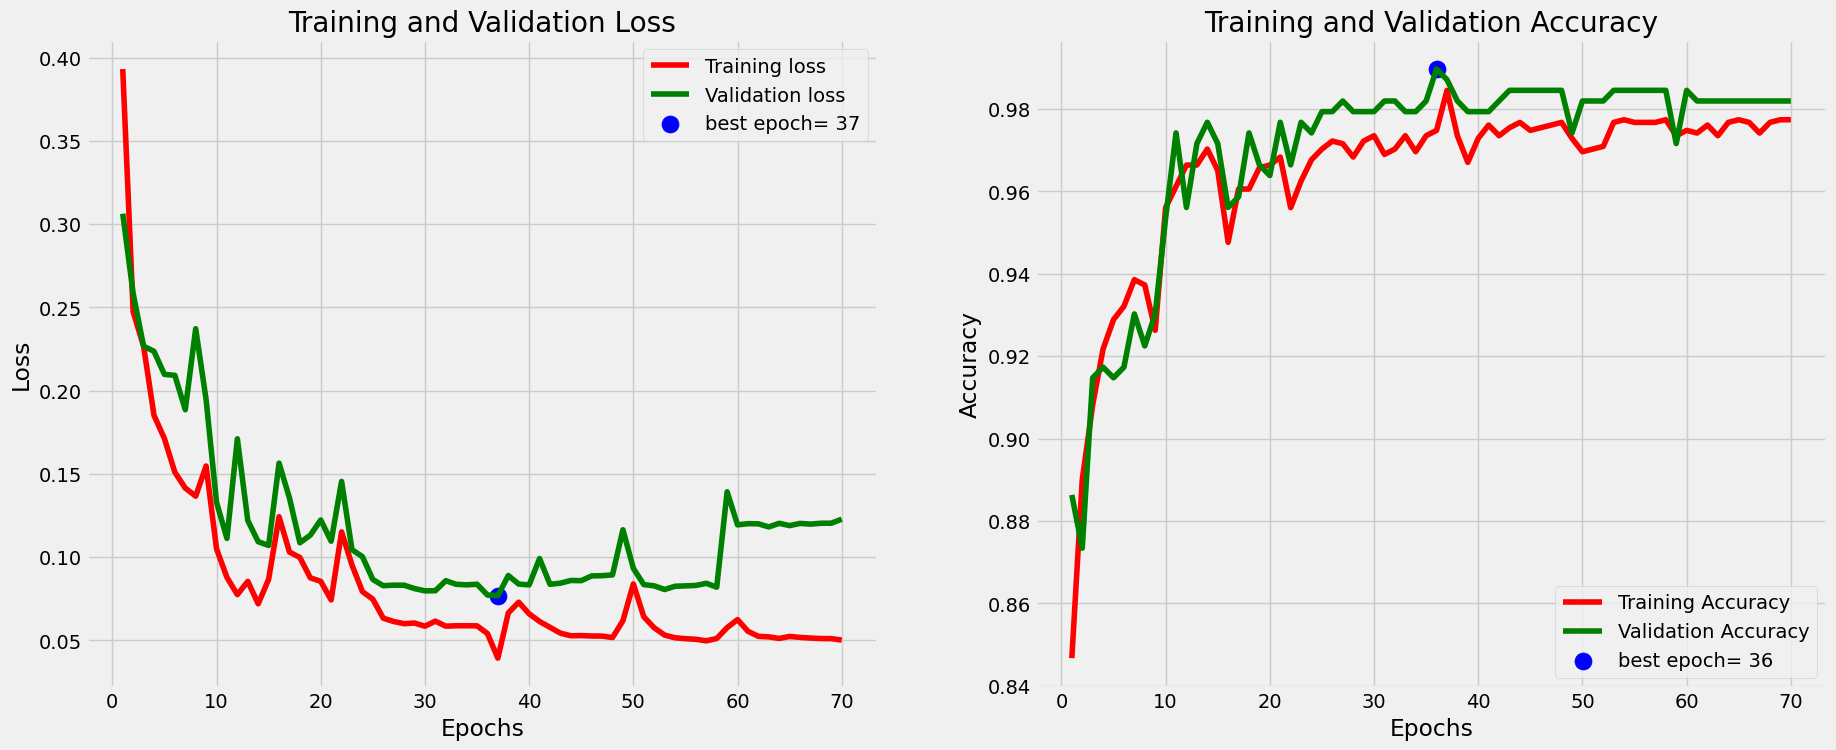

In [23]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [24]:
# Muat bobot dari file HDF5
model.load_weights('Checkpoints/model_epoch_36.h5')

In [25]:
y_pred_prob = model.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

13/13 [==============================] - 0s 11ms/step
Accuracy: 0.99
Precision: 0.99
Recall: 0.98
F1-Score: 0.98


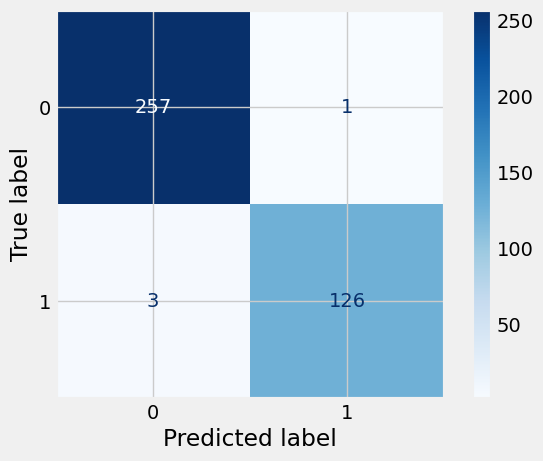

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()